# Exploration

This notebook is used for functional exploration, in order to figure out how things work, so that they then can be implemented in the allskycam.py-Module


In [44]:
import allskycam

import ipywidgets as widgets
from IPython.display import display

from io import BytesIO
from time import sleep
from picamera import PiCamera

from matplotlib import pyplot as plt

import time
import numpy as np

## Camera capture to stream and display single image using PiCamera

In [7]:
stream = BytesIO()

# grab image from camera
with PiCamera() as camera:
    camera.capture(stream, format='jpeg')
    stream.seek(0)
    jpeg_image = stream.read()

# display image
widgets.Image(
    value=jpeg_image,
    format='jpg',
    width=900
)

Image(value=b'\xff\xd8\xff\xe1c\xdcExif\x00\x00MM\x00*\x00\x00\x00\x08\x00\n\x01\x00\x00\x04\x00\x00\x00\x01\x…

## Camera capture to stream and display sequence of images using PiCamera

In [8]:
stream = BytesIO()

wgt = widgets.Image(
    format='jpeg',
    width=900
)
display(wgt)

# grab image from camera
with PiCamera() as camera:
    for i in range(10):
        camera.capture(stream, format='jpeg')
        stream.seek(0)
        jpeg_image = stream.read()
        wgt.value = jpeg_image

Image(value=b'', format='jpeg', width='900')

## Acessing and controlling the camera

It is very important to set both, framerate as well as shutter_speed to consistant values.

If the frame_rate is too high, it is not possible to reach the exposure time, if the frame_rate is too low, a lot of time is needed to finalize the image capture sequence.

In this example, the frame rate time is set 1 second longer than the exposure time.

In [37]:
from picamera import PiCamera
from time import sleep
from fractions import Fraction
PiCamera.CAPTURE_TIMEOUT = 240

In [114]:
stream = BytesIO()
expt = 1

t0 = time.time()
with PiCamera( framerate=Fraction(1, expt+1), sensor_mode=3) as camera:
    allskycam.set_analog_gain(camera, 1)
    allskycam.set_digital_gain(camera, 1)
    camera.resolution = (1024, 768)
    camera.still_stats = False
    camera.shutter_speed = expt*1000000
    camera.awb_gains = (2, 2.5)
    camera.exposure_mode = 'off'
    camera.awb_mode = 'off'
    camera.capture(stream, format='jpeg',bayer=True)
    stream.seek(0)
    jpeg_image = stream.read()
    t1 = time.time()
print('%3.2f seconds'%(t1-t0))

2.64 seconds


In [115]:
imw = widgets.Image(format='jpg')
imw.value = jpeg_image
display(imw)

Image(value=b'\xff\xd8\xff\xe1c\xccExif\x00\x00MM\x00*\x00\x00\x00\x08\x00\n\x01\x00\x00\x04\x00\x00\x00\x01\x…

In [111]:
# getting the raw image data
stream.seek(0)
raw = allskycam.get_bayer_data_from_stream(stream)

R = raw[0::2,0::2]
G1 = raw[1::2,0::2]
G2 = raw[0::2,1::2]
B = raw[1::2,1::2]

R = R.flatten()
G = np.append(G1.flatten(), G2.flatten())
B = B.flatten()

Gm = np.mean(G)*2
Rm = np.mean(R)
Bm = np.mean(B)

(Gm/Rm, Gm/Bm)

(3.0195791542538504, 2.776585853934087)

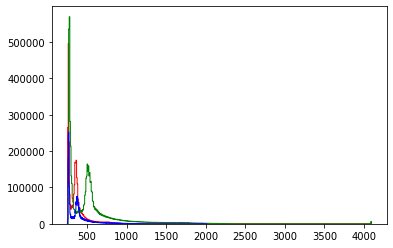

In [104]:
plt.hist(R,512, color='r', histtype=u'step');
plt.hist(G,512, color='g', histtype=u'step');
plt.hist(B,512, color='b', histtype=u'step');